In [9]:
# Import relevant modules
import os
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras.layers as layers
from keras import callbacks
import keras
import uproot
from Sum import Sum
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
import pandas as pd
import hffrag
import keras_tuner as kt
from hffrag import fixedbinning
from hffrag import binneddensity


In [10]:
#A magic operator to allow Jupyter Notebooks to display matplotlib plots as outputs of cells
%matplotlib inline


In [11]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")


In [12]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 8 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 32 # This is the batch size of the mini batches used during training
EPOCHS = 1000 # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 1e20 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate


In [13]:
# Find the associated tracks for each jet
def Match_Tracks(jets, tracks):
    """Used to determine if a set of tracks belong to a particular set of jets"""

    jet_eta = jets["AnalysisAntiKt4TruthJets_eta"]
    jet_phi = jets["AnalysisAntiKt4TruthJets_phi"] 

    tracks_eta = tracks["AnalysisTracks_eta"]
    tracks_phi = tracks["AnalysisTracks_phi"]

    delta_etas = jet_eta - tracks_eta
    delta_phis = np.abs(jet_phi - tracks_phi)

    # Map the phis from a cyclical period onto a linear relation
    ak.where(delta_phis > np.pi, delta_phis - np.pi, delta_phis)

    # Returns a list of true and false, determining which tracks belong to those jets.
    return np.sqrt(delta_phis**2 + delta_etas**2) < 0.4 


In [14]:
# Convert from cylindrical to cartesian coordinates
def pt_eta_phi_2_px_py_pz_jets(pt_eta_phi):
    """Converts the cylindrical polar coordinates to cartesian coordinates for jets"""

    # Seperate the pts, etas and phis
    pts = pt_eta_phi[:, 0:1]
    etas = pt_eta_phi[:, 1:2]
    phis = pt_eta_phi[:, 2:3]

    # Convert from polar to cartesian
    pxs = pts * np.cos(phis)
    pys = pts * np.sin(phis)
    pzs = pts * np.sinh(etas)

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector
    return np.concatenate([pxs, pys, pzs], axis=1)


In [15]:
def pt_eta_phi_2_px_py_pz_tracks(pt_eta_phi, MASKVAL=-999):
    """Converts the cylindrical polar coordinates to cartesian coordinates for jets"""

    # Seperate the pts, etas and phis
    pts = pt_eta_phi[:, :, 0:1]
    etas = pt_eta_phi[:, :, 1:2]
    phis = pt_eta_phi[:, :, 2:3]

    # Convert from polar to cartesian
    # Transforms only the non masked values from cylindrical to cartesian coordinates. Mask values are left unchanged.
    mask1 = pts == MASKVAL 
    mask2 = phis == MASKVAL
    mask3 = etas == MASKVAL
    pxs = np.where(mask1 | mask2, pts, pts * np.cos(phis)) 
    pys = np.where(mask1 | mask2, pts, pts * np.sin(phis))
    pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))

    # Check to see if there are any infinities
    isinf = np.isinf(pzs)

    if np.any(isinf):
        print("Infinities in eta detected!")
        print(etas[isinf])
        raise ValueError("Infinity from sinh(eta) has been detected")

    # Returns the momentum vector in cartesian coordinates
    return np.concatenate([pxs, pys, pzs], axis=2)


In [16]:
def pad(x_values, maxsize, MASKVAL=-999):
    """
    Pads the inputs with nans to get to the maxsize
    """
    #Pad the non-regular arrays with null values until they are all of the same size. Then replace the nulls with MASVAL
    y_values = ak.fill_none(ak.pad_none(x_values, maxsize, axis=1, clip=True), MASKVAL)[:, :maxsize]
    return ak.to_regular(y_values, axis=1) #Return the regular arrays


In [17]:
def flatten(x_values, maxsize=-1, MASKVAL=-999):
    """"Pads the input to ensure they are all of regular size and then zips together result"""
    y_values = {} 
    for field in x_values.fields:
        z_values = x_values[field]
        if maxsize > 0:
            z_values = pad(z_values, maxsize, MASKVAL)
        y_values[field] = z_values

    return ak.zip(y_values)


In [18]:
def LogNormal_Loss_Function(true, meanscovs_matrix):
    """
    This is a loss function hand crafted for the task of ensuring the neural network 
    learns to predict the true value of the transverse momentum and it's uncertainty
    The logNormal constrains the neural network, by forcing upon it what it's output layers should be
    and what the weights and biases of the neural network will be in order to predict the means, variances and covariances
    """
    n_targets = np.shape(true)[1]
    # The first n_target of the features are the means
    means = meanscovs_matrix[:, :n_targets]
    # The second n_target of the feautres are the standard deviations
    logsigma = meanscovs_matrix[:, n_targets:2*n_targets]
    # The rest of the targets are the covariances
    logcosigma = meanscovs_matrix[:,2*n_targets:]

    loss = 0
    for n_target in range(n_targets): #Sum the individual losses and use that as the loss for the neural network
        loss += ((means[:, n_target] - true[:, n_target])**2) / (2 * keras.backend.exp(logsigma[:, n_target])**2) + logsigma[:, n_target]

    # Build loss function
    return loss

In [19]:
def LogNormal_Loss_Function_Check(true,meanscovs_matrix):
    """The role of this function is to calculate the loss for each individual b jet. This is used for the purpose of error checking"""
    n_targets = np.shape(true)[0]
    # Obtain data from convarience matrix
    means = meanscovs_matrix[0, :n_targets]
    # ensure diagonal is postive:
    logsigma = meanscovs_matrix[0, n_targets:2*n_targets]

    loss = 0
    for n_target in range(n_targets):
        loss += ((means[n_target] - true[n_target])**2) / (2 * keras.backend.exp(logsigma[n_target])**2) + logsigma[n_target]

    return loss

In [20]:
def DeepSetNeuralNetwork(track_layers, jet_layers, n_targets,Learning_rate, MASKVAL=-999):
    """
    This function lays out the Deep Set Neural Architecture
    - A neural network is applied first to the tracks to extract information from the tracks.
    - This information produces an ensemble space which, the outputs of which are then summed to produce
        the inputs for the next layer
    - A neural network is then applied to the jet data obtained from the tracks. 
        To perform current univariate regression.
    """
    inputs = layers.Input(shape=(None, track_layers[0])) # Creates a layer for each input
    outputs = inputs  # Creates another layer to pass the inputs onto the ouputs
    outputs = layers.Masking(mask_value=MASKVAL)(outputs) # Masks the MASKVAl values

    counter = 0
    for nodes in track_layers[:-1]:
        #The first neural network is a series of dense layers and is applied to each track using the time distributed layer
        outputs = layers.TimeDistributed( 
            layers.Dense(nodes, activation="relu", kernel_initializer= "he_normal"))(outputs) # We use relu and the corresponding he_normal for the activation function and bias initializer
        if counter % 4 == 0: # Every four layers apply a dropout
            outputs = layers.Dropout(0.01)(outputs)
        else:
            counter += 1
        outputs = layers.BatchNormalization()(outputs) #Apply a batch norm to improve performance by preventing feature bias and overfitting

    outputs = layers.TimeDistributed(layers.Dense( 
        track_layers[-1], activation='softmax'))(outputs) # Apply softmax to ouput the results of the track neural network as probabilities
    outputs = Sum()(outputs) # Sum the outputs to make use of permutation invariance

    counter = 0
    for nodes in jet_layers: #Repeat of the track neural network without the need for the timedistributed layers
        outputs = layers.Dense(nodes, activation='relu', kernel_initializer= "he_normal")(outputs)
        if counter % 4 == 0:
            outputs = layers.Dropout(0.01)(outputs)
        else:
            counter += 1
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.Dense(n_targets+n_targets*(n_targets+1)//2)(outputs) # The output will have a number of neurons needed to form the mean covariance function of the loss func

    Model = keras.Model(inputs=inputs, outputs=outputs) #Create a keras model

    # Specify the neural network's optimizer and loss function
    Model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Learning_rate,clipnorm = 1.0),
    loss=LogNormal_Loss_Function
    )

    return Model


In [21]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]


In [22]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features, entry_stop=MAXEVENTS)

In [23]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]


In [24]:
# Displays the number of jets being trained on
jets = events[jet_features][:, 0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  141329
The number of track features is:  8


In [25]:
# Select tracks from the events
tracks = events[track_features]

# Match the tracks to the jets
matchedtracks = tracks[Match_Tracks(jets, tracks)]

# Pad and Flatten the data
matchedtracks = flatten(matchedtracks, MAXTRACKS)

In [26]:
# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's ppredictions

There are 3 outputs
There are 8 inputs


In [27]:
print(np.shape(bhads)) #Check the shape of the neural network
print(np.shape(jet_features[:-1])) #Check for shape of the jet features
print(jets[jet_features[0]]) # Check the jets

(68143, 3)
(5,)
[1.48e+05, 1.04e+05, 1.16e+05, 4.03e+04, ... 8.14e+04, 9.83e+04, 1.45e+05, 9.11e+04]


In [28]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)
print(np.shape(jets))

(68143, 3)


In [29]:
#Check the matchtracks are the correct shape
print(matchedtracks[:, 0:1])
print(np.shape(matchedtracks[:, :, 3]))

[[[1.47e+04, 0.753, 1.14, 1.19, 75.5, ... -0.165, -0.51, -0.0283, -0.692, -0.038]]]
(68143, 8)


In [30]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
tracks_p = pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = pt_eta_phi_2_px_py_pz_jets(bhads)

#Check the shape of the momenta of the tracks and the rest of the data is consistent
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

(68143, 8, 3)
(68143, 8, 5)


/tmp/ipykernel_17812/1222727277.py:16: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [31]:
#Check that this is all the correct shape
print(np.shape(tracks))
print(tracks[0,0])
print(bhads[0])


(68143, 8, 8)
[6.20926450e+03 1.33553447e+04 1.21693980e+04 1.18753994e+00
 7.55359192e+01 1.33110714e+00 8.57456207e+01 1.32391548e+00]
[ 48855.56531144 128363.19160447 124938.01790683]


In [32]:
# Builds the deep neural network
track_layers = [64, 64, 64, 64, 64, 64]
jet_layers = [128, 128, 128, 128, 128, 128]
DeepNet = DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3, LR)


2022-11-18 12:10:36.332222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-18 12:10:36.332254: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-18 12:10:36.332270: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-11-18 12:10:36.332511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
#Create a Keras model that is a mirror image of the DeepSetNeuralNetwork to tune the hyperparameters of.
def model_builder(hp):
    """
    This function lays out the Deep Set Neural Architecture
    - A neural network is applied first to the tracks to extract information from the tracks.
    - This information produces an ensemble space which, the outputs of which are then summed to produce
        the inputs for the next layer
    - A neural network is then applied to the jet data obtained from the tracks. 
        To perform current univariate regression.
    """
    # Create the ranges of hyperparameters to explore
    dropouts = hp.Choice('dropout', [0.001,0.05,0.20,0.40,0.50])
    track_layer = hp.Choice('track_layers',[32,64,128,256,512])
    jet_layer = hp.Choice('jet_layers',[32,64,128,256,512])
    activation_func = hp.Choice('act_func',["relu","elu"])
    Learning_rate = hp.Choice('learning_rate',[1e-6,1e-5,1e-4,1e-3,1e-2])

    #Create the track and jet layers
    track_layers = [len(track_features)]+[track_layer,track_layer,track_layer,track_layer,track_layer]
    jet_layers = [jet_layer,jet_layer,jet_layer,jet_layer,jet_layer,jet_layer]

    #Set the number of targets being explored
    n_targets = 3
    
    #Follows the DeepSetNeural Architecture
    inputs = layers.Input(shape=(None, track_layers[0]))
    outputs = inputs
    outputs = layers.Masking(mask_value=MASKVAL)(outputs)

    counter = 0
    for nodes in track_layers[:-1]:
        outputs = layers.TimeDistributed(
            layers.Dense(nodes, activation=activation_func, kernel_initializer= "he_normal"))(outputs)
        if counter % 4 == 0:
            outputs = layers.Dropout(dropouts)(outputs)
        else:
            counter += 1
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.TimeDistributed(layers.Dense(
        track_layers[-1], activation='softmax'))(outputs)
    outputs = Sum()(outputs)

    counter = 0
    for nodes in jet_layers:
        outputs = layers.Dense(nodes, activation=activation_func, kernel_initializer= "he_normal")(outputs)
        if counter % 4 == 0:
            outputs = layers.Dropout(0.01)(outputs)
        else:
            counter += 1
        outputs = layers.BatchNormalization()(outputs)

    outputs = layers.Dense(n_targets+n_targets*(n_targets+1)//2)(outputs)

    Model = keras.Model(inputs=inputs, outputs=outputs)

    # Specify the neural network's optimizer and loss function
    Model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=Learning_rate,clipnorm = 1.0),
    loss=LogNormal_Loss_Function
    )

    return Model


In [34]:
#Summarises the Neural Network Architecture
DeepNet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 8)]         0         
                                                                 
 masking (Masking)           (None, None, 8)           0         
                                                                 
 time_distributed (TimeDistr  (None, None, 8)          72        
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 batch_normalization (BatchN  (None, None, 8)          32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, None, 64)         576   

In [35]:
# Split the data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(
    tracks, bhads, train_size=0.7, random_state=42)


In [36]:
#Check for the of the training and validation sets
print(np.shape(X_train), np.shape(y_train))


(47700, 8, 8) (47700, 3)


In [37]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # The minimum amount of change to count as an improvement
    patience=20,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=10, min_lr=1e-6)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints/DeepNetWeights&Biases-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_best_only=True)


In [38]:
# Train the neural network
history = DeepNet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCHSIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_learn_on_plateau,
               cp_callback]  # Enter call back
)


Epoch 1/1000
1491/1491 [==============================] - 13s 6ms/step - loss: 34682830848.0000 - val_loss: 1172928128.0000 - lr: 1.0000e-04
Epoch 2/1000
1491/1491 [==============================] - 9s 6ms/step - loss: 224249104.0000 - val_loss: 1151268.6250 - lr: 1.0000e-04
Epoch 3/1000
1491/1491 [==============================] - 9s 6ms/step - loss: 62801.3281 - val_loss: 35.9062 - lr: 1.0000e-04
Epoch 4/1000
1491/1491 [==============================] - 8s 6ms/step - loss: 35.6293 - val_loss: 35.7847 - lr: 1.0000e-04
Epoch 5/1000
1491/1491 [==============================] - 9s 6ms/step - loss: 35.4560 - val_loss: 35.5294 - lr: 1.0000e-04
Epoch 6/1000
1491/1491 [==============================] - 8s 6ms/step - loss: 35.6007 - val_loss: 34.8613 - lr: 1.0000e-04
Epoch 7/1000
1491/1491 [==============================] - 8s 6ms/step - loss: 35.2616 - val_loss: 35.7822 - lr: 1.0000e-04
Epoch 8/1000
1491/1491 [==============================] - 8s 6ms/step - loss: 35.1702 - val_loss: 35.7439 

<AxesSubplot:>

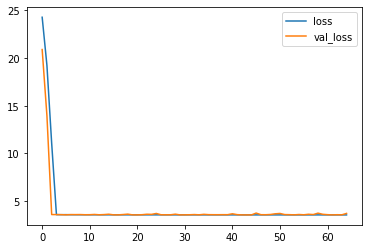

In [39]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
np.log(history_df.loc[:, ["loss", "val_loss"]]).plot()


In [40]:
# Have the model predict the total momentum of the b tracks
predictions = DeepNet.predict(tracks)
# Output the first 10 guesses
print(predictions[:10])


2130/2130 [==============================] - 3s 1ms/step
[[ 2.23265152e+01  5.66946373e+01  2.79504716e-01  1.07514963e+01
   1.09271622e+01  1.19079762e+01  7.21378028e-02  1.84065536e-01
   8.54414165e-01]
 [-6.64195709e+01 -7.19502106e+01  3.82595978e+01  1.07038193e+01
   1.12217703e+01  1.24223518e+01  8.09958637e-01  1.07637219e-01
   3.41384292e+00]
 [ 2.36094723e+01 -4.51908607e+01 -7.43504868e+01  1.09630270e+01
   1.09140368e+01  1.28425274e+01  9.40134048e-01 -2.41652191e-01
   3.12981033e+00]
 [ 3.47411995e+01 -3.18854828e+01 -3.47008858e+01  1.03978806e+01
   1.07678232e+01  1.08860378e+01 -5.60446501e-01  4.48947281e-01
  -8.85602832e-01]
 [ 4.02164955e+01 -4.33705254e+01 -3.18382778e+01  1.07025290e+01
   1.09164705e+01  1.11048279e+01 -5.29282093e-01  1.84754223e-01
  -9.04503107e-01]
 [-6.47926998e+00  5.07267723e+01 -1.04292469e+01  1.05622177e+01
   1.11976576e+01  1.11567516e+01 -2.55458176e-01  4.82984185e-01
   1.54380482e-02]
 [-2.57061119e+01 -3.13163319e+01  1.

In [41]:
# Output to the console the minimum epoch
print("Minimum validation loss: {}".format(history_df["val_loss"].min()))

Minimum validation loss: 34.632205963134766


In [42]:
# Ensure the dimensions are correct
print(len(tracks), len(predictions))
print(np.shape(predictions))

68143 68143
(68143, 9)


In [43]:
# Create the distribution of errors to access the performance of the neural network
pull = (predictions[:, 1] - bhads[:,1])
scaled_pull = pull/np.exp(predictions[:, 4])
# Compare and constrast the true and predicted momentums
print(np.min(predictions[:,1]),np.max(predictions[:,1]))

print("Minimum and maximum values")
print("The min/max of bhad momenta: ", np.min(bhads), np.max(bhads))
print("The min/max of the ppred - ptrue", np.min(pull), np.max(pull))
print("The min/max of the pull", np.min(scaled_pull), np.max(scaled_pull))

print("Median and IQR")
print("The Median/IQR for the ppred - ptrue: ", np.median(pull),
      np.percentile(pull, 75)-np.percentile(pull, 25))
print("The Median/IQR for the pull ", np.median(scaled_pull),
      np.percentile(scaled_pull, 75)-np.percentile(scaled_pull, 25))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(pull), np.std(pull))
print("The mean/std for the pull", np.mean(scaled_pull), np.std(scaled_pull))


-449.26678 148.72632
Minimum and maximum values
The min/max of bhad momenta:  -2273167.0883596055 1827356.5267840482
The min/max of the ppred - ptrue -777768.7593189306 467778.248348503
The min/max of the pull -8.837223442626076 6.256611672050029
Median and IQR
The Median/IQR for the ppred - ptrue:  391.57437455949844 91179.64565455745
The Median/IQR for the pull  0.022520383651363374 1.9038276078766736
Mean and standard deviation
The mean/std for the ppred - ptrue:  52.70477503898669 65389.3419779312
The mean/std for the pull -0.12496589914425724 1.1445492686986536


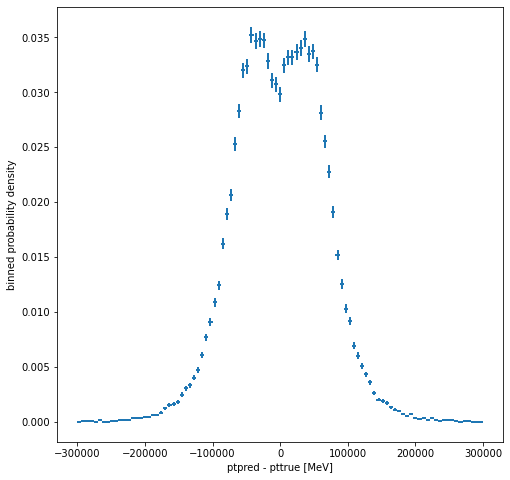

In [44]:
#Plot the distribution of error
fig = binneddensity(pull, fixedbinning(-3e5, 3e5, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig


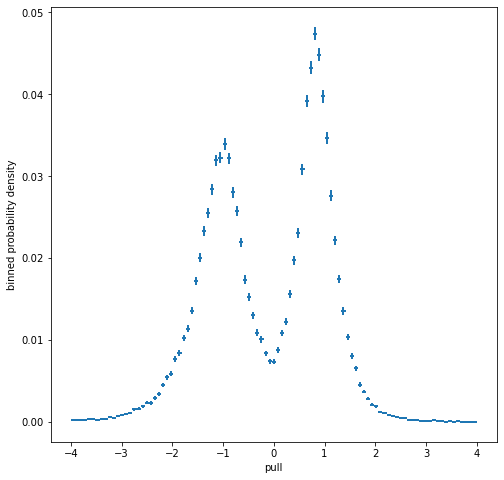

In [45]:
#Plot the distribution of the pull values
fig = binneddensity(scaled_pull, fixedbinning(-4.0, 4.0, 100), xlabel="pull")
fig


In [46]:
#Predict the momentas for a single jet and determine the loss
print(DeepNet.predict(tracks[1]))
print(bhads[1])

LogNormal_Loss_Function_Check(bhads[1],DeepNet.predict(tracks[1]))

1/1 [==============================] - 0s 352ms/step
[[-66.41957    -71.95021     38.259598    10.703819    11.22177
   12.422352     0.80995864   0.10763722   3.413843  ]]
[   843.45625286  77133.74792279 179693.16123271]
1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=35.143463>

In [47]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", round(loss,3))

2130/2130 - 2s - loss: 34.6364 - 2s/epoch - 1ms/step
The Loaded DeepNet has loss:  34.636


In [58]:
#Set up the hyperparameter
SEED = tf.random.set_seed(42) # Generate a random seed
max_trials = 10
tuner = kt.RandomSearch(model_builder,
                        objective='val_loss',
                        seed=SEED,
                        overwrite=True,
                        max_trials=15,
                        directory='/home/physics/phujdj/DeepLearningParticlePhysics',
                        project_name="DeepSetHyperTraining",
                        )


In [59]:
#Create an early stoping to properly survey the values
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [60]:
#Search the parameter space to obtain the best hyperparameter values
tuner.search(X_train, y_train, validation_data=(
    X_valid, y_valid), epochs=20, callbacks=[stop_early])


Trial 15 Complete [00h 03m 16s]
val_loss: 35.309566497802734

Best val_loss So Far: 34.592384338378906
Total elapsed time: 00h 39m 40s
INFO:tensorflow:Oracle triggered exit


In [61]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]
print(f"""
The hyperparameter search is complete. The optimal number of track layers is {best_hps.get('track_layers')}, the optimal number of jet layers is {best_hps.get('jet_layers')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the optimal dropout rate is {best_hps.get('dropout')} and finally the optimal activation function is {best_hps.get('act_func')}
""")



The hyperparameter search is complete. The optimal number of track layers is 512, the optimal number of jet layers is 128, the optimal learning rate for the optimizer
is 0.0001, the optimal dropout rate is 0.05 and finally the optimal activation function is elu

